In [2]:

import json
import torch

# Load vocabulary mappings (ensure one-time loading)
with open("assets/word_to_index.json", "r") as f:
    word_to_index = json.load(f)


with open("assets/index_to_word.json", "r") as f:
    index_to_word = json.load(f)
    index_to_word = {int(k): v for k, v in index_to_word.items()}


vocab_size = len(word_to_index)  # Make sure it matches training vocab size

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


# Define the improved MLP model
class ImprovedMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_rate, context_size, activation_function):
        super(ImprovedMLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * context_size, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.activation_function = activation_function

    def forward(self, x):
        x = self.embedding(x).view(x.size(0), -1)
        x = self.dropout1(self.activation_function(self.bn1(self.fc1(x))))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


embedding_dim = 32
hidden_dim = 1024
dropout_rate = 0.3
context_size = 5
activation_function = nn.LeakyReLU()
model = ImprovedMLP(vocab_size, embedding_dim,hidden_dim, dropout_rate, context_size, activation_function)

# Example loading for a PyTorch model
model_path = "models/model_context_5_emb_32_act_leaky_relu_seed_42.pth"
# Load the state dictionary
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Extract embeddings
embedding_layer = model.embedding.weight.detach().cpu().numpy


In [4]:
# Extract embeddings as a PyTorch tensor
embedding_layer = model.embedding.weight.detach().cpu()

# Confirm the type and view the shape
print("Type of embedding_layer:", type(embedding_layer))
print("Shape of embedding_layer:", embedding_layer.shape)
print("First few entries of the embedding layer:", embedding_layer[:5])


Type of embedding_layer: <class 'torch.Tensor'>
Shape of embedding_layer: torch.Size([14343, 32])
First few entries of the embedding layer: tensor([[ 0.1607, -0.8831,  0.9053,  0.3046,  1.1314, -0.0213,  0.0537, -1.3349,
         -0.3744,  1.6580, -0.4364,  0.9736, -0.0852, -1.8226,  0.0389,  0.8106,
          1.3936, -1.3252, -0.4490, -0.1550, -0.0816,  1.4668,  0.7676,  0.6426,
          0.9667,  2.3175, -1.0444, -0.4604, -1.4124,  0.2381,  0.3254,  0.7909],
        [-1.9379,  1.2617,  1.4001,  0.5934, -1.6363,  0.1354,  0.5916,  3.0951,
          2.2618,  0.7057,  0.2028, -1.7554,  0.9461,  0.0473, -0.2410, -0.4252,
         -0.4355,  0.5923,  2.8197,  0.5316, -1.4165,  1.7443, -1.1300,  1.0919,
          0.1573, -0.7654, -0.7492,  2.1439,  0.8276, -0.5683, -1.9366, -1.9796],
        [ 1.4292, -0.9563,  2.4447, -0.4073, -1.9755, -2.1960, -1.1864,  0.7653,
         -0.7518, -1.6341, -1.0671,  1.1376,  1.8026, -0.4890, -4.2620, -1.3836,
         -0.9479,  1.3315,  1.4379,  1.1982,  1.

In [5]:
print(len(word_to_index))

14343


### Visualization

Closest words: chicken and meat
Furthest words: fry and and


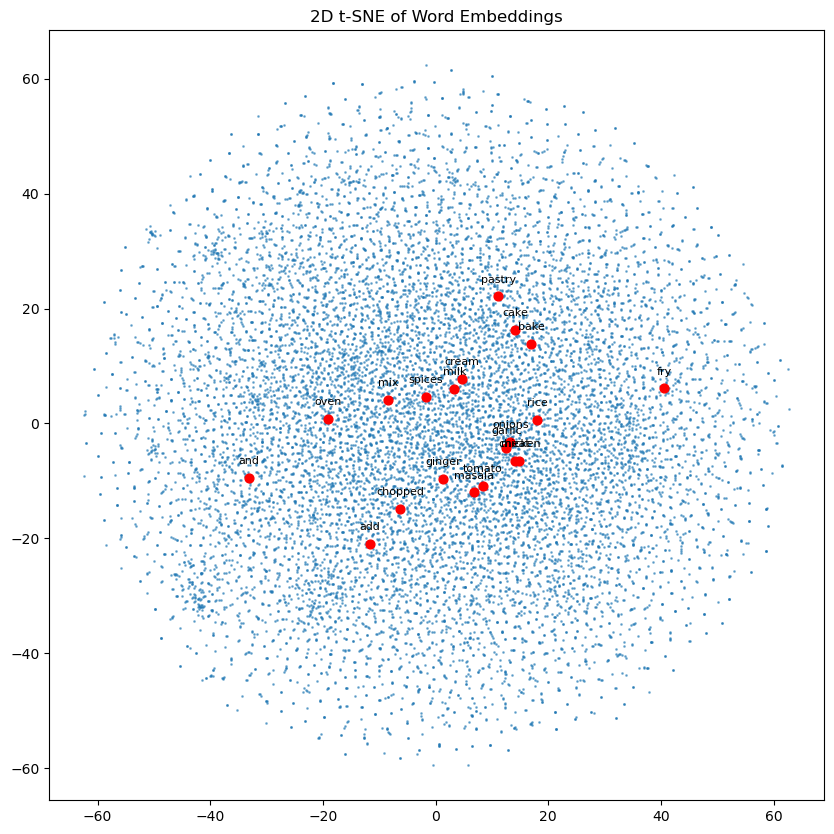

In [18]:
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np

# Reduce embedding dimensionality
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_layer.cpu())

# Words to annotate and analyze
words_to_annotate = ["bake", "cake", "chicken", "meat", "rice", "milk", "cream", "fry", "oven", "masala", "pastry", "and", "add", "mix", "chopped", "onions","tomato","garlic","ginger","spices"]
indices = [word_to_index[word] for word in words_to_annotate]
annotated_embeddings = reduced_embeddings[indices]

# Compute pairwise distances
distances = pairwise_distances(annotated_embeddings)

# Find closest and furthest pairs
closest_pair_indices = np.unravel_index(np.argmin(distances + np.eye(len(distances)) * distances.max()), distances.shape)
furthest_pair_indices = np.unravel_index(np.argmax(distances), distances.shape)

print("Closest words:", words_to_annotate[closest_pair_indices[0]], "and", words_to_annotate[closest_pair_indices[1]])
print("Furthest words:", words_to_annotate[furthest_pair_indices[0]], "and", words_to_annotate[furthest_pair_indices[1]])

# Plot embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5, s=1)
plt.title("2D t-SNE of Word Embeddings")

# Annotate specified words
for word in words_to_annotate:
    index = word_to_index[word]
    x, y = reduced_embeddings[index]
    plt.scatter(x, y, color='red', s=40)
    plt.annotate(word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

plt.show()


In [9]:
import re

def clean_and_tokenize(text):
    if text is None or text.strip() == "":
        return []
    

    text = text.replace('start', ' start ').replace('end', ' end ')
    
    text = re.sub(r'([.,!?])', r' \1 ', text)  # Add spaces around punctuation marks
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    segments = text.lower().split() # Split text into segments
    
    return segments 

Closest words: chess and chess
Furthest words: chess and chess


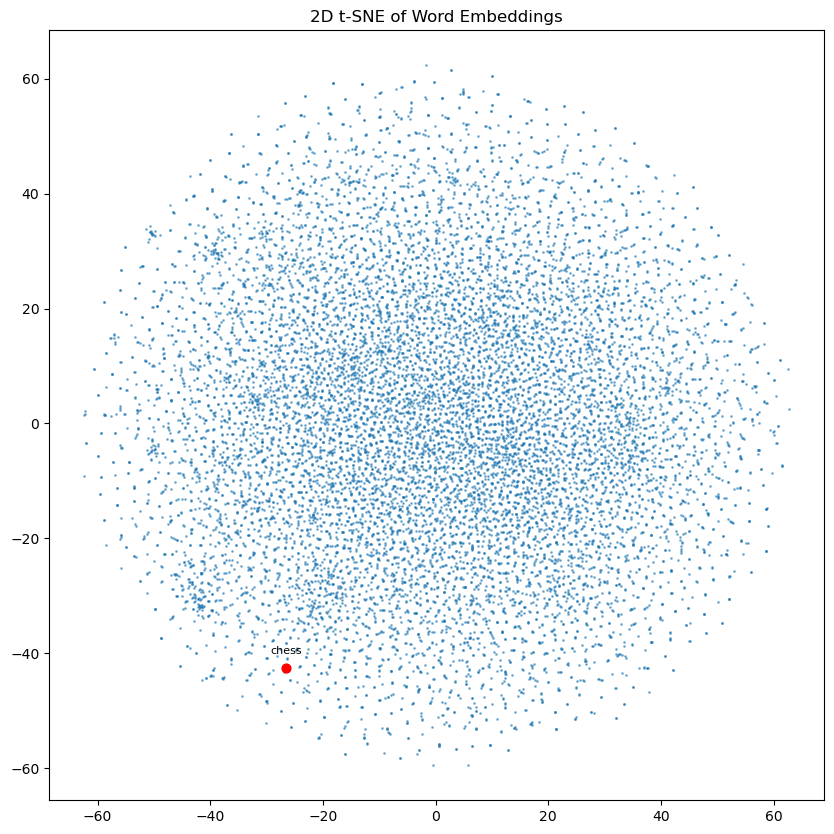

In [19]:
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np

# Reduce embedding dimensionality
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_layer.cpu())

# Words to annotate and analyze
words_to_annotate = ["chess"]

cleaned_words_to_annotate = [clean_and_tokenize(word)[0] for word in words_to_annotate]
indices = [word_to_index.get(word, word_to_index['pad']) for word in cleaned_words_to_annotate]
annotated_embeddings = reduced_embeddings[indices]

# Compute pairwise distances
distances = pairwise_distances(annotated_embeddings)

# Find closest and furthest pairs
closest_pair_indices = np.unravel_index(np.argmin(distances + np.eye(len(distances)) * distances.max()), distances.shape)
furthest_pair_indices = np.unravel_index(np.argmax(distances), distances.shape)

print("Closest words:", words_to_annotate[closest_pair_indices[0]], "and", words_to_annotate[closest_pair_indices[1]])
print("Furthest words:", words_to_annotate[furthest_pair_indices[0]], "and", words_to_annotate[furthest_pair_indices[1]])

# Plot embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5, s=1)
plt.title("2D t-SNE of Word Embeddings")

# Annotate specified words
for word in words_to_annotate:
    index = word_to_index.get(word, word_to_index['pad'])
    x, y = reduced_embeddings[index]
    plt.scatter(x, y, color='red', s=40)
    plt.annotate(word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

plt.show()
